# Analyzing Major European Leagues 

In the following notebook:
1. Data is cleaned
2. Home matches and away matches are separated into groups
3. Exploratory data analysis is carried for each group
4. Stattistical tests for significance are performed to compare the differences
5. Some more exploratory analysis is done based on the significant findings
6. Probability models are constructed using the differences between home and away performance and combinations of algorithms 

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from scipy import stats
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,RandomizedSearchCV
from sklearn.metrics import roc_auc_score,confusion_matrix,recall_score,classification_report,mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel,f_regression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from scipy.stats import poisson
from scipy.stats import skellam
from scipy.stats import randint as sp_randint
%matplotlib inline

In [2]:
#For neural Network
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [3]:
df = pd.read_csv('FootballEurope.csv', low_memory=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9127 entries, 0 to 9126
Data columns (total 94 columns):
Unnamed: 0                 9127 non-null int64
id                         9127 non-null int64
homeTacklesTotalHT         9127 non-null int64
homeShotsTotalHT           9127 non-null int64
awayDispossessedFT         9126 non-null float64
awayPassSuccessFT          9127 non-null float64
awayRatingsFT              9127 non-null float64
awayDribbleSuccessFT       9125 non-null float64
awayDribblesAttemptedHT    9127 non-null int64
awayTeamLineUp             9127 non-null object
awayShotsBlockedHT         8906 non-null float64
awayShotsTotalHT           9126 non-null float64
homeDribbleSuccessHT       9124 non-null float64
homeFoulsCommitedFT        9127 non-null int64
homeAerialsTotalFT         9127 non-null int64
homeRatingsHT              9127 non-null float64
awayShotsOnTargetFT        9069 non-null float64
awayShotsBlockedFT         8906 non-null float64
homeInterceptionsHT       

In [5]:
df.head(3)

,Unnamed: 0,id,homeTacklesTotalHT,homeShotsTotalHT,awayDispossessedFT,awayPassSuccessFT,awayRatingsFT,awayDribbleSuccessFT,awayDribblesAttemptedHT,awayTeamLineUp,...,homeInterceptionsFT,homePassSuccessHT,date,awayTacklesTotalFT,homeRatingsFT,homeDribblesAttemptedFT,homeTackleSuccessFT,awayPossessionFT,awayShotsTotalFT,division
0,1,1,18,10,14.0,73.69,6.38,47.22,12,"Joel Robles,Paul Scharner,Antolin Alcaraz,Emme...",...,21,69.45,2013-05-14,18,6.73,12.0,75.00,52.35,11.0,EPL
1,2,2,13,3,11.0,75.78,6.39,27.27,5,"Petr Cech,César Azpilicueta,Branislav Ivanovic...",...,14,78.64,2012-11-03,26,6.37,13.0,88.89,46.29,11.0,EPL
2,3,3,10,5,16.0,74.86,6.73,66.67,4,"Anders Lindegaard,Antonio Valencia,Phil Jones,...",...,5,75.31,2013-05-19,20,6.04,11.0,75.00,60.18,15.0,EPL


In [6]:
years = []
months = []
days = []

for i in range(len(df['date'])):
    years.append(df['date'][i].split('-')[0])
    months.append(df['date'][i].split('-')[1])
    days.append(df['date'][i].split('-')[2])
    
df["Year"] = years
df["Month"] = months
df["Day"] = days

df['Year'] = df['Year'].apply(pd.to_numeric)
df['Month'] = df['Month'].apply(pd.to_numeric)
df['Day'] = df['Day'].apply(pd.to_numeric)

In [7]:
df = df.drop('Unnamed: 0', axis=1)

In [8]:
df.drop('id', axis=1).describe()

,homeTacklesTotalHT,homeShotsTotalHT,awayDispossessedFT,awayPassSuccessFT,awayRatingsFT,awayDribbleSuccessFT,awayDribblesAttemptedHT,awayShotsBlockedHT,awayShotsTotalHT,homeDribbleSuccessHT,...,homePassSuccessHT,awayTacklesTotalFT,homeRatingsFT,homeDribblesAttemptedFT,homeTackleSuccessFT,awayPossessionFT,awayShotsTotalFT,Year,Month,Day
count,9127.000000,9127.000000,9126.000000,9127.000000,9127.000000,9125.000000,9127.000000,8906.000000,9126.000000,9124.000000,...,9127.000000,9127.000000,9127.000000,9126.000000,9127.000000,9127.000000,9126.000000,9127.000000,9127.000000,9127.000000
mean,13.378328,6.384464,11.542735,66.551030,6.439506,51.522129,7.682809,1.205255,5.047776,51.747545,...,69.755104,29.178810,6.513104,17.774381,71.066465,38.885950,11.294872,2014.524597,6.416128,15.959242
std,4.873219,3.037856,4.596256,8.826947,0.214911,17.167074,3.887593,1.221407,2.668439,22.734890,...,9.325749,8.365003,0.216431,6.948109,11.226337,20.675034,4.575210,1.504112,3.824577,8.896591
min,0.000000,0.000000,0.000000,0.000000,5.620000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,5.670000,0.000000,0.000000,0.000000,0.000000,2012.000000,1.000000,1.000000
25%,10.000000,4.000000,8.000000,60.675000,6.300000,40.000000,5.000000,0.000000,3.000000,37.405000,...,63.425000,23.000000,6.370000,13.000000,63.790000,35.410000,8.000000,2013.000000,3.000000,8.000000
50%,13.000000,6.000000,11.000000,66.890000,6.430000,50.000000,7.000000,1.000000,5.000000,50.000000,...,70.280000,29.000000,6.500000,17.000000,71.590000,45.590000,11.000000,2015.000000,5.000000,17.000000
75%,16.000000,8.000000,14.000000,72.875000,6.570000,62.500000,10.000000,2.000000,7.000000,66.670000,...,76.660000,34.000000,6.650000,22.000000,78.690000,52.710000,14.000000,2016.000000,10.000000,23.000000
max,39.000000,25.000000,36.000000,91.730000,7.410000,100.000000,32.000000,10.000000,18.000000,100.000000,...,93.560000,77.000000,7.530000,51.000000,100.000000,79.320000,35.000000,2017.000000,12.000000,31.000000


In [9]:
data_numeric = df.select_dtypes(exclude=[object]) 

In [11]:
num_columns = df.drop('id', axis=1).describe().columns.tolist()

In [12]:
home_num_columns = []
away_num_columns = []
standard_num_columns = []

for i in range(len(num_columns)):
    if num_columns[i].startswith('home'):
        home_num_columns.append(num_columns[i])
    elif num_columns[i].startswith('away'):
        away_num_columns.append(num_columns[i])
    else:
        standard_num_columns.append(num_columns[i])

In [13]:
print(len(num_columns))
print(len(home_num_columns))
print(len(away_num_columns))
print(len(standard_num_columns))

83
40
40
3


In [14]:
FT_away_num_columns = []
HT_away_num_columns = []

for i in range(len(away_num_columns)):
    if away_num_columns[i].endswith('HT'):
        HT_away_num_columns.append(away_num_columns[i])
    else:
        FT_away_num_columns.append(away_num_columns[i])

In [15]:
FT_home_num_columns = []
HT_home_num_columns = []

for i in range(len(home_num_columns)):
    if home_num_columns[i].endswith('HT'):
        HT_home_num_columns.append(home_num_columns[i])
    else:
        FT_home_num_columns.append(home_num_columns[i])

In [16]:
cat_columns = list(set(df.drop('id', axis=1).columns) - set(df.drop('id', axis=1).describe().columns))

In [17]:
home_cat_columns = []
away_cat_columns = []
standard_cat_columns = ['id']

for i in range(len(cat_columns)):
    if cat_columns[i].startswith('home'):
        home_cat_columns.append(cat_columns[i])
    elif cat_columns[i].startswith('away'):
        away_cat_columns.append(cat_columns[i])
    else:
        standard_cat_columns.append(cat_columns[i])

In [18]:
for i in cat_columns:
    
    if np.any(df[i].unique() == 'null'):
        for j in range(len(df[i].values)):
            if df[i].values[j] == 'null':
                df[i].values[j] = None
 
print('Percentage of Missing Values in Each Column')
print(((df.isnull().sum() / df.isnull().sum().sum())*100).sort_values(axis=0, ascending=False))

Percentage of Missing Values in Each Column
awayOffsidesCaughtFT       14.200092
awayOffsidesCaughtHT       14.200092
homeOffsidesCaughtHT       12.309820
homeOffsidesCaughtFT       12.309820
awayShotsBlockedFT         10.189027
awayShotsBlockedHT         10.189027
homeShotsBlockedFT          4.933149
homeShotsBlockedHT          4.933149
awayShotsOnTargetHT         2.674043
awayShotsOnTargetFT         2.674043
awayCornersTotalHT          2.351314
awayCornersTotalFT          2.351314
homeShotsOnTargetHT         1.106501
homeCornersTotalFT          1.106501
homeShotsOnTargetFT         1.106501
homeCornersTotalHT          1.106501
awayPassesKeyHT             0.230521
awayPassesKeyFT             0.230521
homeDribblesWonFT           0.138313
homeDribblesWonHT           0.138313
awayDribbledPastHT          0.138313
homeDribbleSuccessHT        0.138313
homeDribbleSuccessFT        0.138313
awayDribbledPastFT          0.138313
homeDribbledPastHT          0.092208
awayDribbleSuccessHT        0.0

# Exploring Away Matches

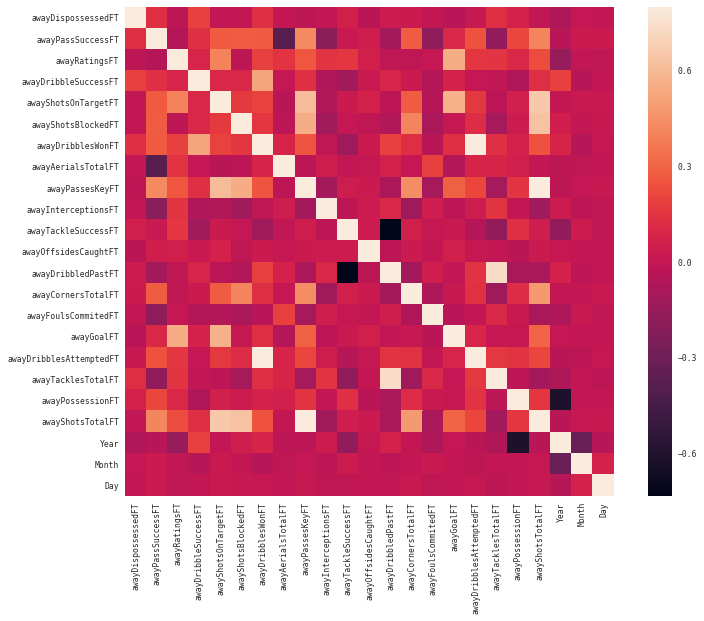

In [19]:
sns.set(context="paper", font="monospace")
corrmat = df[FT_away_num_columns + standard_num_columns].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

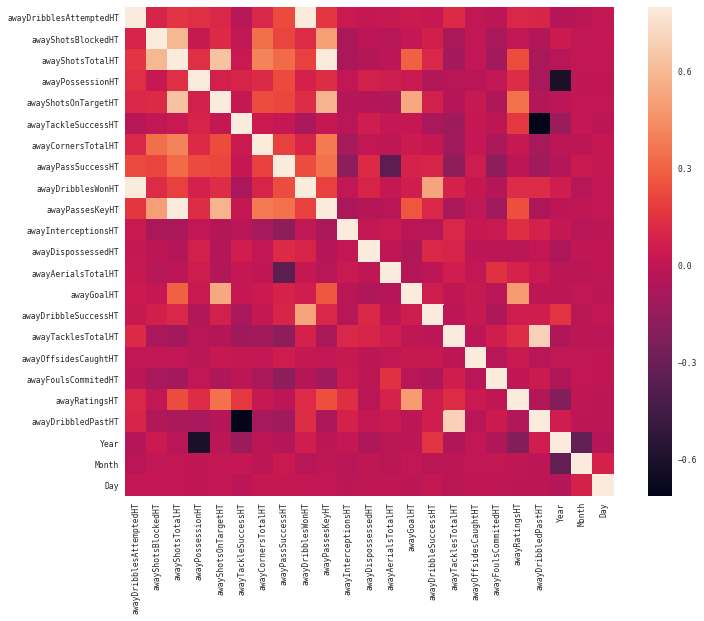

In [20]:
corrmat = df[HT_away_num_columns + standard_num_columns].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [21]:
corr_matrix = df[FT_away_num_columns + standard_num_columns].corr()

def get_redundant_pairs(df):
    
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(corr_matrix, 30))

Top Absolute Correlations
awayPassesKeyFT       awayShotsTotalFT           0.994214
awayTackleSuccessFT   awayDribbledPastFT         0.885720
awayDribblesWonFT     awayDribblesAttemptedFT    0.876350
awayDribbledPastFT    awayTacklesTotalFT         0.871542
awayPossessionFT      Year                       0.842601
awayShotsBlockedFT    awayShotsTotalFT           0.838433
awayShotsOnTargetFT   awayPassesKeyFT            0.832066
                      awayShotsTotalFT           0.828382
awayShotsBlockedFT    awayPassesKeyFT            0.811118
awayShotsOnTargetFT   awayGoalFT                 0.784786
awayRatingsFT         awayGoalFT                 0.777244
awayCornersTotalFT    awayShotsTotalFT           0.760374
awayShotsBlockedFT    awayCornersTotalFT         0.753245
awayPassesKeyFT       awayCornersTotalFT         0.739948
awayPassSuccessFT     awayPassesKeyFT            0.690245
                      awayShotsTotalFT           0.679847
                      awayAerialsTotalFT      

In [22]:
corr_matrix = df[HT_away_num_columns + standard_num_columns].corr()

print("Top Absolute Correlations")
print(get_top_abs_correlations(corr_matrix, 30))

Top Absolute Correlations
awayShotsTotalHT         awayPassesKeyHT         0.991530
awayDribblesAttemptedHT  awayDribblesWonHT       0.882947
awayTackleSuccessHT      awayDribbledPastHT      0.871228
awayTacklesTotalHT       awayDribbledPastHT      0.841457
awayPossessionHT         Year                    0.837482
awayShotsTotalHT         awayShotsOnTargetHT     0.824319
awayShotsOnTargetHT      awayPassesKeyHT         0.815271
awayShotsBlockedHT       awayShotsTotalHT        0.797312
awayShotsOnTargetHT      awayGoalHT              0.775004
awayShotsBlockedHT       awayPassesKeyHT         0.768639
awayGoalHT               awayRatingsHT           0.732479
awayShotsTotalHT         awayCornersTotalHT      0.681317
awayCornersTotalHT       awayPassesKeyHT         0.667282
awayShotsBlockedHT       awayCornersTotalHT      0.656187
awayPassSuccessHT        awayAerialsTotalHT      0.647517
awayDribblesWonHT        awayDribbleSuccessHT    0.619784
awayPassSuccessHT        awayPassesKeyHT      

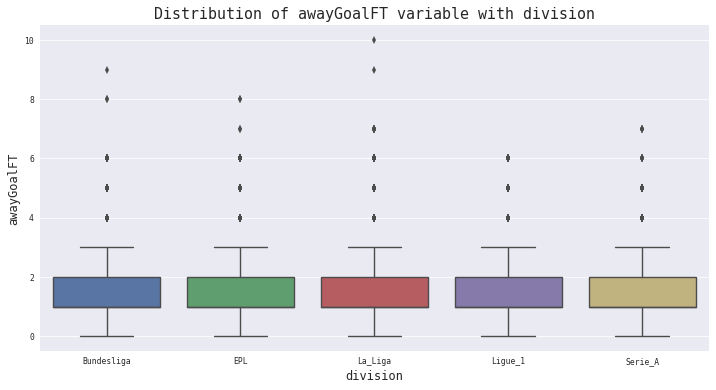

In [23]:
var_name = "division"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var_name, y='homeGoalFT', data=df, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('awayGoalFT', fontsize=12)
plt.title("Distribution of awayGoalFT variable with "+var_name, fontsize=15)
plt.show()

In [24]:
df.groupby('division')['awayGoalFT'].describe()

,count,mean,std,min,25%,50%,75%,max
division,,,,,,,,
Bundesliga,1529.0,1.278613,1.208963,0.0,0.0,1.0,2.0,7.0
EPL,1900.0,1.185789,1.159119,0.0,0.0,1.0,2.0,7.0
La_Liga,1900.0,1.165263,1.171926,0.0,0.0,1.0,2.0,8.0
Ligue_1,1899.0,1.071617,1.110412,0.0,0.0,1.0,2.0,9.0
Serie_A,1899.0,1.183254,1.134344,0.0,0.0,1.0,2.0,7.0


EPL has the highest mean for away full time goals, while La liga had the highest standard deviation

In [25]:
corr_matrix = df[FT_away_num_columns + standard_num_columns].corr()
corr_matrix['awayGoalFT'].sort_values(axis=0, ascending=False)[1:]

awayShotsOnTargetFT        0.568663
awayRatingsFT              0.551342
awayShotsTotalFT           0.297331
awayPassesKeyFT            0.289585
awayDribblesWonFT          0.126613
awayPassSuccessFT          0.103648
awayDribblesAttemptedFT    0.087470
awayDribbleSuccessFT       0.079450
awayOffsidesCaughtFT       0.059946
awayTackleSuccessFT        0.023787
awayCornersTotalFT         0.019945
awayShotsBlockedFT         0.014699
awayPossessionFT           0.009322
awayTacklesTotalFT         0.007598
Year                       0.003697
Month                      0.002025
Day                       -0.000540
awayDribbledPastFT        -0.008850
awayInterceptionsFT       -0.022110
awayFoulsCommitedFT       -0.037802
awayDispossessedFT        -0.038064
awayAerialsTotalFT        -0.050448
Name: awayGoalFT, dtype: float64

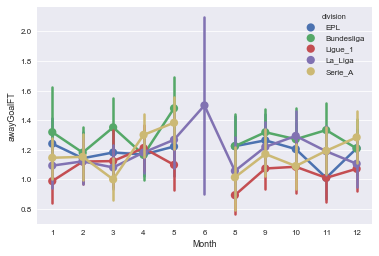

In [26]:
sns.set_style("darkgrid")
ax = sns.pointplot(x="Month", y="awayGoalFT", hue='division', data=df)
plt.show()

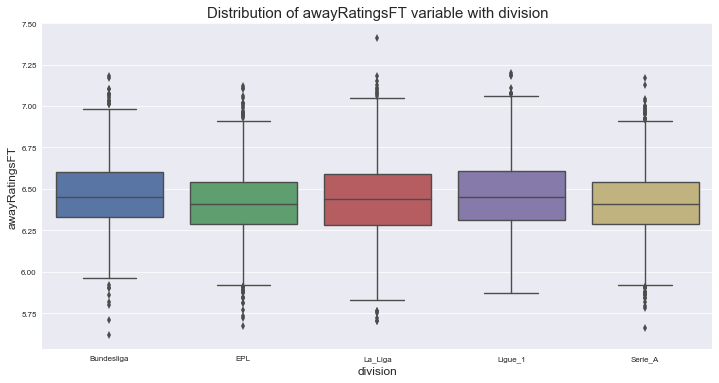

In [27]:
var_name = "division"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var_name, y='awayRatingsFT', data=df, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('awayRatingsFT', fontsize=12)
plt.title("Distribution of awayRatingsFT variable with "+var_name, fontsize=15)
plt.show()

In [28]:
df.groupby('division')['awayRatingsFT'].describe()

,count,mean,std,min,25%,50%,75%,max
division,,,,,,,,
Bundesliga,1529.0,6.464545,0.212960,5.62,6.33,6.45,6.60,7.18
EPL,1900.0,6.422389,0.204565,5.67,6.29,6.41,6.54,7.12
La_Liga,1900.0,6.437200,0.234868,5.70,6.28,6.44,6.59,7.41
Ligue_1,1899.0,6.462375,0.216399,5.87,6.31,6.45,6.61,7.20
Serie_A,1899.0,6.415908,0.199476,5.66,6.29,6.41,6.54,7.17


Bundesliga has the highest mean away ranking

In [29]:
corr_matrix = df[FT_away_num_columns + standard_num_columns].corr()
corr_matrix['awayRatingsFT'].sort_values(axis=0, ascending=False)[1:]

awayGoalFT                 0.551342
awayShotsOnTargetFT        0.400083
awayPassesKeyFT            0.255849
awayShotsTotalFT           0.228165
awayDribblesWonFT          0.189239
awayTackleSuccessFT        0.156085
awayDribblesAttemptedFT    0.155835
awayTacklesTotalFT         0.152216
awayInterceptionsFT        0.145342
awayAerialsTotalFT         0.144010
awayPossessionFT           0.101107
awayDribbleSuccessFT       0.090515
awayOffsidesCaughtFT       0.058110
awayFoulsCommitedFT        0.007281
Month                     -0.003295
awayCornersTotalFT        -0.010204
Day                       -0.014175
awayDribbledPastFT        -0.014242
awayShotsBlockedFT        -0.017561
awayDispossessedFT        -0.018642
awayPassSuccessFT         -0.055471
Year                      -0.158165
Name: awayRatingsFT, dtype: float64

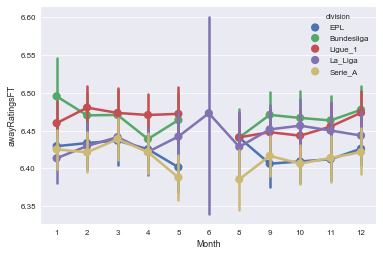

In [30]:
sns.set_style("darkgrid")
ax = sns.pointplot(x="Month", y="awayRatingsFT", hue='division', data=df)
plt.show()

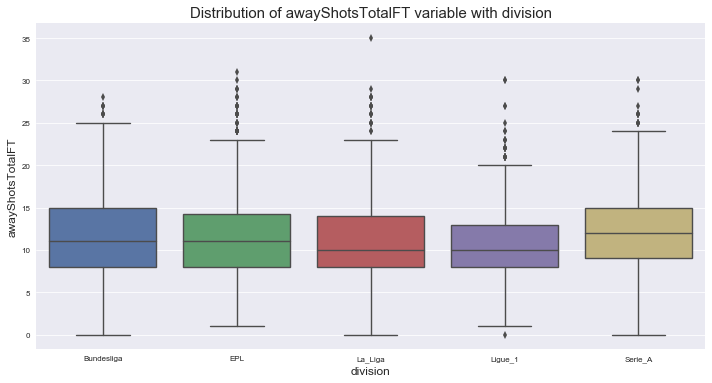

In [31]:
var_name = "division"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var_name, y='awayShotsTotalFT', data=df, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('awayShotsTotalFT', fontsize=12)
plt.title("Distribution of awayShotsTotalFT variable with "+var_name, fontsize=15)
plt.show()

In [32]:
df.groupby('division')['awayShotsTotalFT'].describe()

,count,mean,std,min,25%,50%,75%,max
division,,,,,,,,
Bundesliga,1529.0,11.702420,4.664784,0.0,8.0,11.0,15.00,28.0
EPL,1900.0,11.690000,4.810709,1.0,8.0,11.0,14.25,31.0
La_Liga,1900.0,10.828421,4.588608,0.0,8.0,10.0,14.00,35.0
Ligue_1,1898.0,10.416228,4.046982,0.0,8.0,10.0,13.00,30.0
Serie_A,1899.0,11.916272,4.567471,0.0,9.0,12.0,15.00,30.0


For away shots SerieA has the highest score, while EPL has the highest variance

In [33]:
corr_matrix = df[FT_away_num_columns + standard_num_columns].corr()
corr_matrix['awayShotsTotalFT'].sort_values(axis=0, ascending=False)[1:]

awayPassesKeyFT            0.912957
awayShotsOnTargetFT        0.659185
awayShotsBlockedFT         0.637122
awayCornersTotalFT         0.479277
awayPassSuccessFT          0.414454
awayGoalFT                 0.297331
awayDribblesWonFT          0.245673
awayRatingsFT              0.228165
awayDribblesAttemptedFT    0.209238
awayPossessionFT           0.157767
awayDribbleSuccessFT       0.125564
awayTackleSuccessFT        0.049202
awayOffsidesCaughtFT       0.026894
Day                        0.015176
Month                      0.014776
awayAerialsTotalFT        -0.002889
awayDispossessedFT        -0.007954
Year                      -0.031265
awayFoulsCommitedFT       -0.086343
awayDribbledPastFT        -0.089626
awayTacklesTotalFT        -0.110012
awayInterceptionsFT       -0.122568
Name: awayShotsTotalFT, dtype: float64

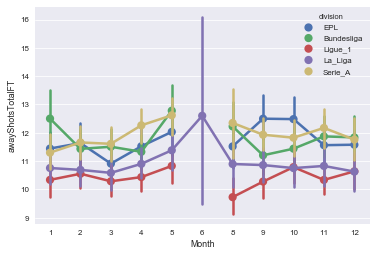

In [34]:
sns.set_style("darkgrid")
ax = sns.pointplot(x="Month", y="awayShotsTotalFT", hue='division', data=df)
plt.show()

In [35]:
df['awayGoalPerShotsTotalFT'] = df["awayGoalFT"]/df["awayShotsTotalFT"]

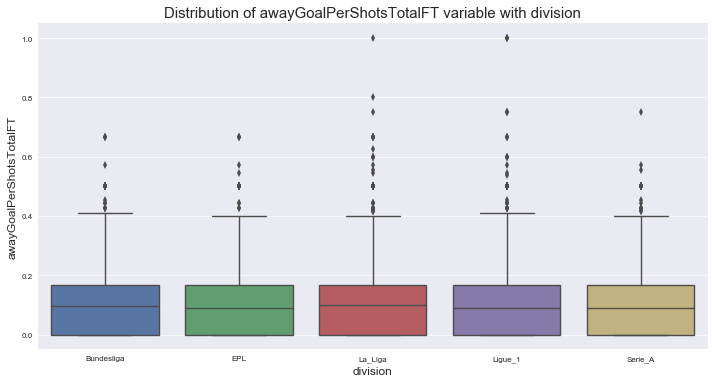

In [36]:
var_name = "division"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var_name, y='awayGoalPerShotsTotalFT', data=df, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('awayGoalPerShotsTotalFT', fontsize=12)
plt.title("Distribution of awayGoalPerShotsTotalFT variable with "+var_name, fontsize=15)
plt.show()

In [37]:
df.groupby('division')['awayGoalPerShotsTotalFT'].describe()

,count,mean,std,min,25%,50%,75%,max
division,,,,,,,,
Bundesliga,1528.0,0.113834,0.110802,0.0,0.0,0.097619,0.166667,0.666667
EPL,1900.0,0.105037,0.107284,0.0,0.0,0.090909,0.166667,0.666667
La_Liga,1899.0,0.114013,0.118947,0.0,0.0,0.100000,0.166667,1.000000
Ligue_1,1898.0,inf,NaN,0.0,0.0,0.090909,0.166667,inf
Serie_A,1898.0,0.104050,0.102023,0.0,0.0,0.090909,0.166667,0.750000


Mean away goals per shot were the highest for LaLiga, while SerieA has the lowest mean for goals per shots

In [38]:
corr_matrix = df[FT_away_num_columns + standard_num_columns + ['awayGoalPerShotsTotalFT']].corr()
corr_matrix['awayGoalPerShotsTotalFT'].sort_values(axis=0, ascending=False)[1:]

awayGoalFT                 0.812146
awayRatingsFT              0.428746
awayShotsOnTargetFT        0.258373
awayOffsidesCaughtFT       0.044348
awayTacklesTotalFT         0.044164
awayInterceptionsFT        0.026938
awayDribbledPastFT         0.017565
awayDribbleSuccessFT       0.012396
awayFoulsCommitedFT        0.006564
awayDribblesWonFT          0.006297
awayTackleSuccessFT        0.005054
Year                       0.004723
Month                      0.003181
Day                       -0.009722
awayDribblesAttemptedFT   -0.013626
awayAerialsTotalFT        -0.026050
awayDispossessedFT        -0.040019
awayPossessionFT          -0.047646
awayPassesKeyFT           -0.092174
awayPassSuccessFT         -0.102300
awayShotsTotalFT          -0.114498
awayCornersTotalFT        -0.165565
awayShotsBlockedFT        -0.221749
Name: awayGoalPerShotsTotalFT, dtype: float64

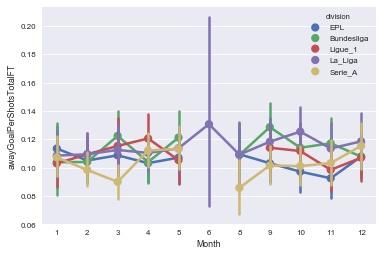

In [39]:
sns.set_style("darkgrid")
ax = sns.pointplot(x="Month", y="awayGoalPerShotsTotalFT", hue='division', data=df)
plt.show()

In [40]:
df.groupby('awayTeam')['awayGoalPerShotsTotalFT'].describe().sort_values('mean',ascending=False)

,count,mean,std,min,25%,50%,75%,max
awayTeam,,,,,,,,
Valenciennes,38.0,inf,NaN,0.0,0.000000,0.066667,0.125000,inf
Barcelona,95.0,0.176812,0.127601,0.0,0.083333,0.166667,0.256579,0.545455
PSG,95.0,0.163585,0.125156,0.0,0.080128,0.142857,0.200000,0.750000
Alaves,19.0,0.162162,0.177788,0.0,0.000000,0.090909,0.242857,0.500000
Real Madrid,95.0,0.151136,0.101225,0.0,0.076923,0.125000,0.222222,0.421053
RasenBallsport Leipzig,17.0,0.150384,0.114506,0.0,0.076923,0.166667,0.250000,0.333333
Bayern,85.0,0.148758,0.116165,0.0,0.066667,0.142857,0.200000,0.666667
Monaco,76.0,0.147761,0.104952,0.0,0.075549,0.127717,0.222222,0.500000
AC Ajaccio,38.0,0.145071,0.235770,0.0,0.000000,0.088462,0.195455,1.000000


# Exploring Home Matches

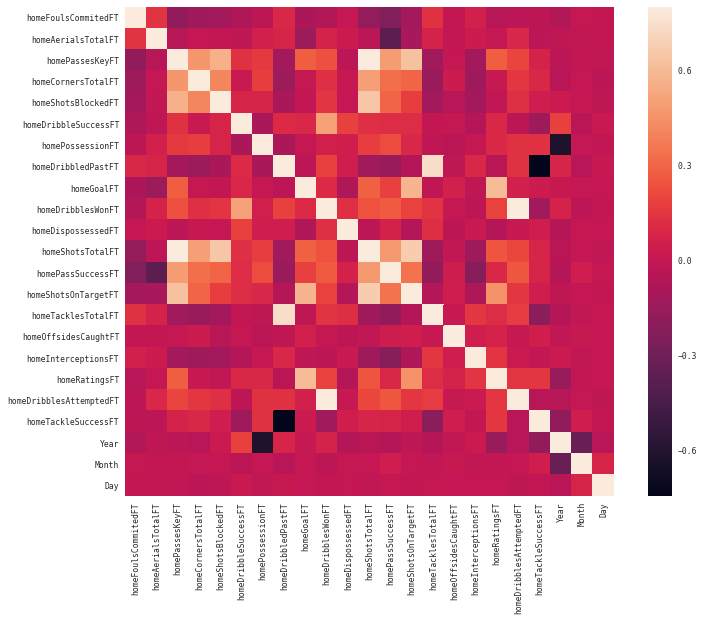

In [41]:
sns.set(context="paper", font="monospace")
corrmat = df[FT_home_num_columns + standard_num_columns].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

plt.show()

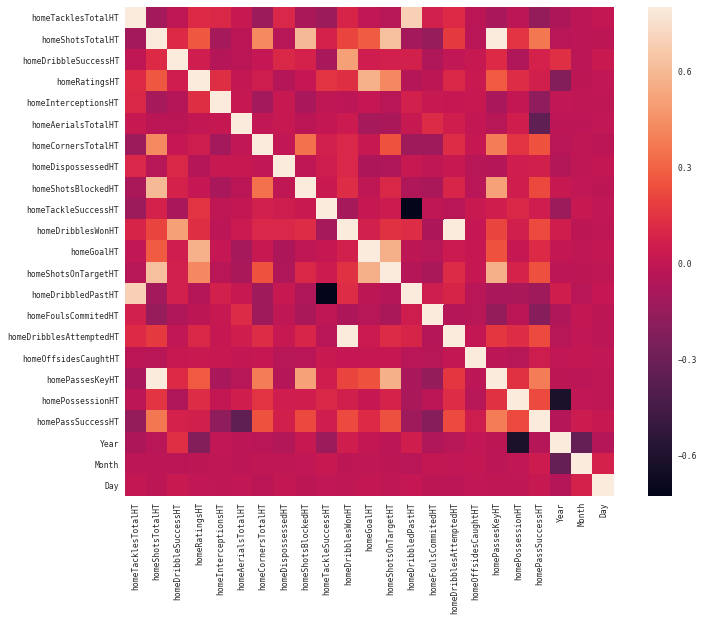

In [42]:
corrmat2 = df[HT_home_num_columns + standard_num_columns].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat2, vmax=.8, square=True)

In [43]:
corr_matrix2 = df[FT_home_num_columns + standard_num_columns].corr()

print("Top Absolute Correlations")
print(get_top_abs_correlations(corr_matrix2, 30))

Top Absolute Correlations
homePassesKeyFT       homeShotsTotalFT           0.995171
homeDribbledPastFT    homeTackleSuccessFT        0.902092
                      homeTacklesTotalFT         0.883556
homeDribblesWonFT     homeDribblesAttemptedFT    0.869110
homeShotsBlockedFT    homeShotsTotalFT           0.849864
homePassesKeyFT       homeShotsOnTargetFT        0.849199
homeGoalFT            homeRatingsFT              0.847139
homePossessionFT      Year                       0.844967
homeShotsTotalFT      homeShotsOnTargetFT        0.841990
homePassesKeyFT       homeShotsBlockedFT         0.823426
homeCornersTotalFT    homeShotsTotalFT           0.793189
homeGoalFT            homeShotsOnTargetFT        0.793068
homePassesKeyFT       homePassSuccessFT          0.785370
                      homeCornersTotalFT         0.778289
homeShotsTotalFT      homePassSuccessFT          0.775366
homeCornersTotalFT    homeShotsBlockedFT         0.768514
                      homePassSuccessFT       

In [44]:
corr_matrix = df[HT_home_num_columns + standard_num_columns].corr()

print("Top Absolute Correlations")
print(get_top_abs_correlations(corr_matrix, 30))

Top Absolute Correlations
homeShotsTotalHT      homePassesKeyHT            0.991524
homeTackleSuccessHT   homeDribbledPastHT         0.888057
homeDribblesWonHT     homeDribblesAttemptedHT    0.878646
homeTacklesTotalHT    homeDribbledPastHT         0.845954
homePossessionHT      Year                       0.836509
homeRatingsHT         homeGoalHT                 0.822373
homeShotsTotalHT      homeShotsOnTargetHT        0.805990
                      homeShotsBlockedHT         0.803253
homeShotsOnTargetHT   homePassesKeyHT            0.797929
homeGoalHT            homeShotsOnTargetHT        0.792305
homeShotsBlockedHT    homePassesKeyHT            0.775698
homeShotsTotalHT      homeCornersTotalHT         0.716178
homeCornersTotalHT    homePassesKeyHT            0.697294
                      homeShotsBlockedHT         0.668525
homeRatingsHT         homeShotsOnTargetHT        0.667455
homePassesKeyHT       homePassSuccessHT          0.656954
homeShotsTotalHT      homePassSuccessHT       

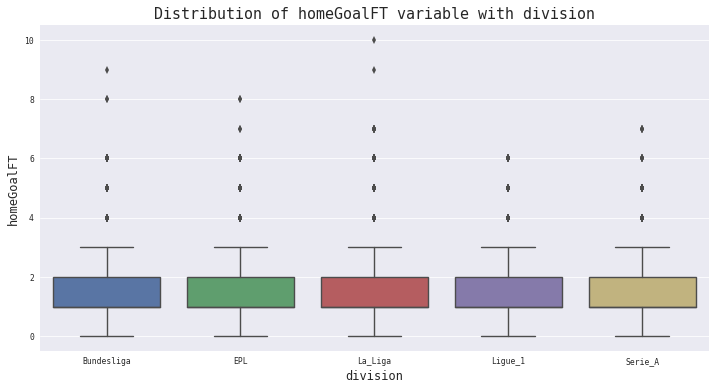

In [45]:
var_name = "division"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var_name, y='homeGoalFT', data=df, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('homeGoalFT', fontsize=12)
plt.title("Distribution of homeGoalFT variable with "+var_name, fontsize=15)
plt.show()

In [46]:
df.groupby('division')['homeGoalFT'].describe()

,count,mean,std,min,25%,50%,75%,max
division,,,,,,,,
Bundesliga,1529.0,1.631131,1.345916,0.0,1.0,1.0,2.0,9.0
EPL,1900.0,1.538421,1.303819,0.0,1.0,1.0,2.0,8.0
La_Liga,1900.0,1.627368,1.427957,0.0,1.0,1.0,2.0,10.0
Ligue_1,1899.0,1.454450,1.236265,0.0,1.0,1.0,2.0,6.0
Serie_A,1899.0,1.534492,1.256069,0.0,1.0,1.0,2.0,7.0


home full time goals were the highest for Bundesliga, standard deviation for LaLiga

In [47]:
corr_matrix = df[FT_home_num_columns + standard_num_columns].corr()
corr_matrix['homeGoalFT'].sort_values(axis=0, ascending=False)[1:]

homeRatingsFT              0.605448
homeShotsOnTargetFT        0.578529
homeShotsTotalFT           0.281149
homePassesKeyFT            0.277505
homePassSuccessFT          0.189705
homeDribblesWonFT          0.104657
homeDribbleSuccessFT       0.088380
homeDribblesAttemptedFT    0.057628
homeOffsidesCaughtFT       0.057484
homeTackleSuccessFT        0.029581
Year                       0.012046
homeCornersTotalFT         0.006917
homePossessionFT           0.003369
Day                       -0.001936
Month                     -0.002434
homeShotsBlockedFT        -0.006100
homeInterceptionsFT       -0.017018
homeTacklesTotalFT        -0.017094
homeDribbledPastFT        -0.033030
homeDispossessedFT        -0.074631
homeFoulsCommitedFT       -0.083890
homeAerialsTotalFT        -0.147900
Name: homeGoalFT, dtype: float64

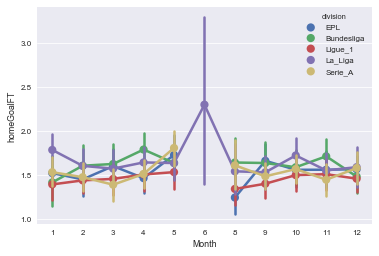

In [48]:
sns.set_style("darkgrid")
ax = sns.pointplot(x="Month", y="homeGoalFT", hue='division', data=df)
plt.show()

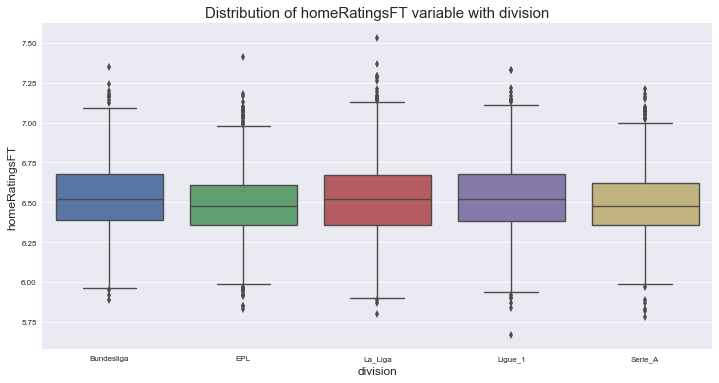

In [49]:
var_name = "division"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var_name, y='homeRatingsFT', data=df, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('homeRatingsFT', fontsize=12)
plt.title("Distribution of homeRatingsFT variable with "+var_name, fontsize=15)
plt.show()

In [50]:
df.groupby('division')['homeRatingsFT'].describe()

,count,mean,std,min,25%,50%,75%,max
division,,,,,,,,
Bundesliga,1529.0,6.535121,0.215119,5.89,6.39,6.52,6.68,7.35
EPL,1900.0,6.489500,0.203004,5.83,6.36,6.48,6.61,7.41
La_Liga,1900.0,6.526837,0.234634,5.80,6.36,6.52,6.67,7.53
Ligue_1,1899.0,6.528241,0.218375,5.67,6.38,6.52,6.68,7.33
Serie_A,1899.0,6.490116,0.205124,5.78,6.36,6.48,6.62,7.21


Bundesliga has the highest ratings

In [51]:
corr_matrix = df[FT_home_num_columns + standard_num_columns].corr()
corr_matrix['homeRatingsFT'].sort_values(axis=0, ascending=False)[1:]

homeGoalFT                 0.605448
homeShotsOnTargetFT        0.452560
homePassesKeyFT            0.277199
homeShotsTotalFT           0.248884
homeDribblesWonFT          0.191558
homeDribblesAttemptedFT    0.153210
homeTackleSuccessFT        0.150566
homeInterceptionsFT        0.146511
homeTacklesTotalFT         0.111627
homePassSuccessFT          0.098994
homeDribbleSuccessFT       0.097332
homePossessionFT           0.097042
homeOffsidesCaughtFT       0.071960
homeCornersTotalFT         0.012301
Day                        0.001478
homeAerialsTotalFT        -0.002871
Month                     -0.004834
homeShotsBlockedFT        -0.012854
homeDribbledPastFT        -0.038181
homeFoulsCommitedFT       -0.049667
homeDispossessedFT        -0.054372
Year                      -0.156458
Name: homeRatingsFT, dtype: float64

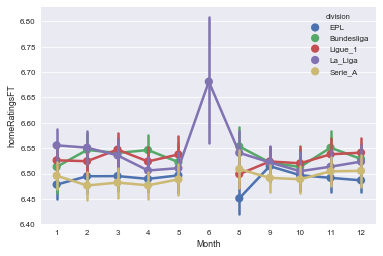

In [52]:
sns.set_style("darkgrid")
ax = sns.pointplot(x="Month", y="homeRatingsFT", hue='division', data=df)
plt.show()

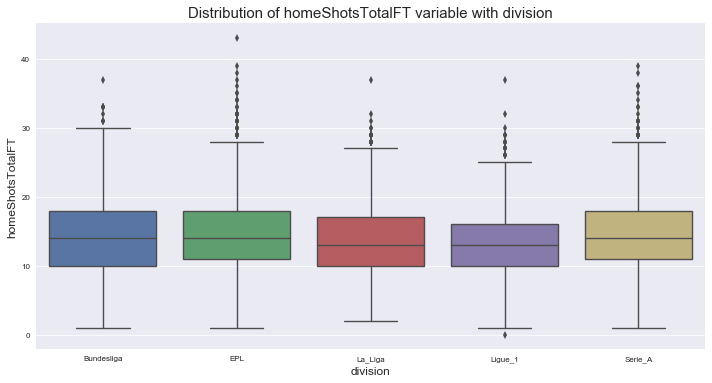

In [53]:
var_name = "division"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var_name, y='homeShotsTotalFT', data=df, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('homeShotsTotalFT', fontsize=12)
plt.title("Distribution of homeShotsTotalFT variable with "+var_name, fontsize=15)
plt.show()

In [54]:
df.groupby('division')['homeShotsTotalFT'].describe()

,count,mean,std,min,25%,50%,75%,max
division,,,,,,,,
Bundesliga,1529.0,14.247220,5.399883,1.0,10.0,14.0,18.0,37.0
EPL,1900.0,14.722105,5.705576,1.0,11.0,14.0,18.0,43.0
La_Liga,1900.0,13.675789,4.975362,2.0,10.0,13.0,17.0,37.0
Ligue_1,1899.0,13.092154,4.581476,0.0,10.0,13.0,16.0,37.0
Serie_A,1899.0,14.522380,5.419387,1.0,11.0,14.0,18.0,39.0


Serie A has the highest mean shots

In [55]:
corr_matrix = df[FT_home_num_columns + standard_num_columns].corr()
corr_matrix['homeShotsTotalFT'].sort_values(axis=0, ascending=False)[1:]

homePassesKeyFT            0.916782
homeShotsOnTargetFT        0.668954
homeShotsBlockedFT         0.648373
homeCornersTotalFT         0.496776
homePassSuccessFT          0.475944
homeGoalFT                 0.281149
homeRatingsFT              0.248884
homeDribblesWonFT          0.241091
homeDribblesAttemptedFT    0.204027
homePossessionFT           0.173819
homeDribbleSuccessFT       0.128619
homeTackleSuccessFT        0.085048
Month                     -0.001500
homeOffsidesCaughtFT      -0.012721
Day                       -0.014932
homeDispossessedFT        -0.024651
homeAerialsTotalFT        -0.027644
Year                      -0.039208
homeDribbledPastFT        -0.129222
homeInterceptionsFT       -0.134429
homeTacklesTotalFT        -0.139378
homeFoulsCommitedFT       -0.168121
Name: homeShotsTotalFT, dtype: float64

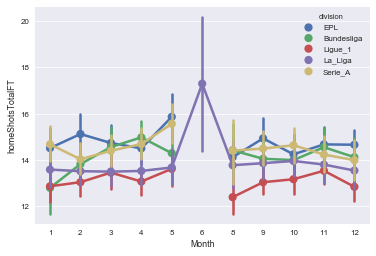

In [56]:
sns.set_style("darkgrid")
ax = sns.pointplot(x="Month", y="homeShotsTotalFT", hue='division', data=df)
plt.show()

In [57]:
df['homeGoalPerShotsTotalFT'] = df["homeGoalFT"]/df["homeShotsTotalFT"]

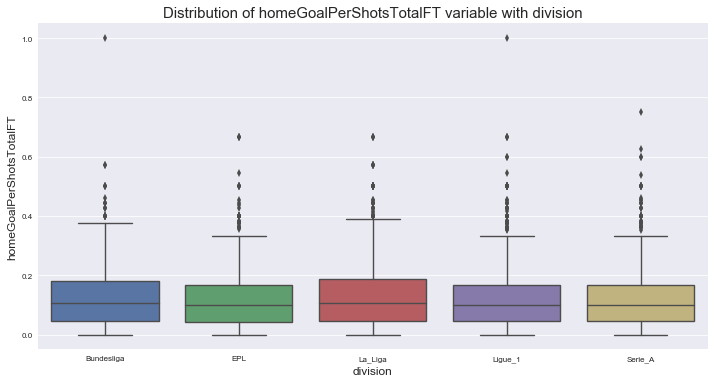

In [58]:
var_name = "division"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var_name, y='homeGoalPerShotsTotalFT', data=df, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('homeGoalPerShotsTotalFT', fontsize=12)
plt.title("Distribution of homeGoalPerShotsTotalFT variable with "+var_name, fontsize=15)
plt.show()

In [59]:
df.groupby('division')['homeGoalPerShotsTotalFT'].describe()

,count,mean,std,min,25%,50%,75%,max
division,,,,,,,,
Bundesliga,1529.0,0.119246,0.100781,0.0,0.047619,0.105263,0.181818,1.000000
EPL,1900.0,0.110636,0.096344,0.0,0.041667,0.100000,0.166667,0.666667
La_Liga,1900.0,0.123874,0.108214,0.0,0.047619,0.107143,0.187500,0.666667
Ligue_1,1898.0,0.118201,0.106444,0.0,0.047619,0.100000,0.166667,1.000000
Serie_A,1899.0,0.111813,0.097244,0.0,0.045455,0.100000,0.166667,0.750000


In LaLiga home games we observed the highest accuracy in goals but also the highest variance 

In [60]:
corr_matrix = df[FT_home_num_columns + standard_num_columns + ['homeGoalPerShotsTotalFT']].corr()
corr_matrix['homeGoalPerShotsTotalFT'].sort_values(axis=0, ascending=False)[1:]

homeGoalFT                 0.819310
homeRatingsFT              0.469796
homeShotsOnTargetFT        0.251602
homeOffsidesCaughtFT       0.056768
homeTacklesTotalFT         0.038373
homeInterceptionsFT        0.037318
Year                       0.029412
homeDribbleSuccessFT       0.025547
homeDribbledPastFT         0.016327
homeFoulsCommitedFT        0.003810
Day                        0.000352
homeTackleSuccessFT       -0.003747
Month                     -0.004546
homeDribblesWonFT         -0.014597
homeDribblesAttemptedFT   -0.044205
homePassSuccessFT         -0.047137
homeDispossessedFT        -0.061752
homePossessionFT          -0.070896
homeAerialsTotalFT        -0.116504
homePassesKeyFT           -0.123220
homeShotsTotalFT          -0.156790
homeCornersTotalFT        -0.197534
homeShotsBlockedFT        -0.260582
Name: homeGoalPerShotsTotalFT, dtype: float64

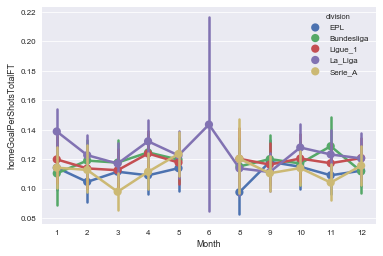

In [61]:
sns.set_style("darkgrid")
ax = sns.pointplot(x="Month", y="homeGoalPerShotsTotalFT", hue='division', data=df)
plt.show()

In [62]:
df.groupby('homeTeam')['homeGoalPerShotsTotalFT'].describe().sort_values('mean',ascending=False)

,count,mean,std,min,25%,50%,75%,max
homeTeam,,,,,,,,
Barcelona,95.0,0.199220,0.099812,0.0,0.117647,0.200000,0.277778,0.400000
Real Madrid,95.0,0.170007,0.092172,0.0,0.111455,0.153846,0.217391,0.428571
PSG,95.0,0.169958,0.117515,0.0,0.090909,0.148148,0.228758,0.545455
Bayern,85.0,0.157461,0.097094,0.0,0.083333,0.136364,0.217391,0.444444
Atletico,95.0,0.157147,0.106762,0.0,0.071429,0.153846,0.230769,0.428571
Borussia M.Gladbach,85.0,0.153602,0.109661,0.0,0.062500,0.142857,0.230769,0.444444
Sevilla,95.0,0.151627,0.111752,0.0,0.071429,0.133333,0.222222,0.500000
Villarreal,76.0,0.149546,0.116840,0.0,0.070238,0.142857,0.216270,0.500000
Monaco,76.0,0.148283,0.116863,0.0,0.076923,0.125000,0.188702,0.666667


Though we observe imbalanced classes because the number of games played by each team is not the same, we can see that the teams that had high goal accuracy at home had high goal accuracy away as well

# Comperative Statistical Testing for Significance

Top Absolute Correlations
homeDribbledPastHT       awayDribblesWonHT          1.000000
homeAerialsTotalHT       awayAerialsTotalHT         1.000000
homeDribblesWonHT        awayDribbledPastHT         1.000000
awayShotsTotalHT         awayPassesKeyHT            0.993592
homeShotsTotalHT         homePassesKeyHT            0.993490
awayDribblesAttemptedHT  awayDribblesWonHT          0.925299
homeDribbledPastHT       awayDribblesAttemptedHT    0.925294
homeDribblesAttemptedHT  awayDribbledPastHT         0.920832
homeDribblesWonHT        homeDribblesAttemptedHT    0.920805
homeDribblesAttemptedHT  awayTacklesTotalHT         0.911001
homeTacklesTotalHT       awayDribblesAttemptedHT    0.907987
homeTackleSuccessHT      awayDribbleSuccessHT       0.899397
homeDribbleSuccessHT     awayTackleSuccessHT        0.892577
homeTackleSuccessHT      homeDribbledPastHT         0.884338
                         awayDribblesWonHT          0.884307
awayShotsTotalHT         awayShotsOnTargetHT        0.87087

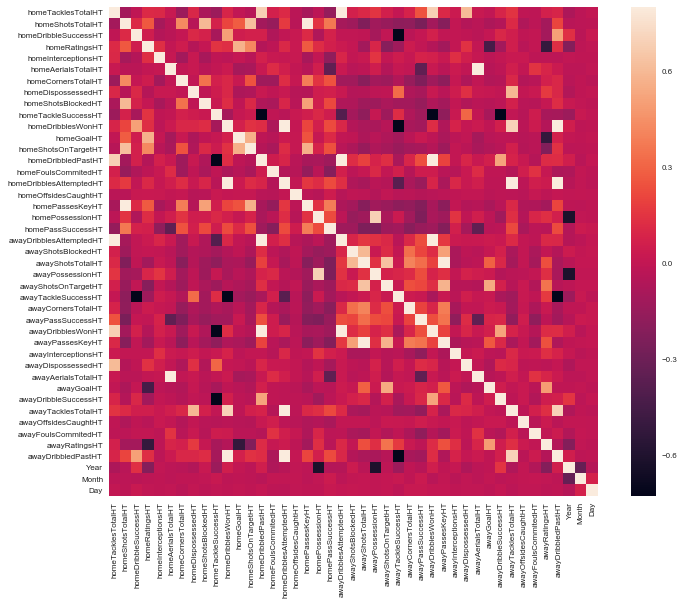

In [63]:
corr_matrix3 = df[HT_home_num_columns + HT_away_num_columns + standard_num_columns].corr()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix3, vmax=.8, square=True)

print("Top Absolute Correlations")
print(get_top_abs_correlations(corr_matrix3, 40))

In [64]:
print(stats.spearmanr(df['homeGoalHT'], df['awayGoalHT'], axis=0))
print(stats.spearmanr(df['homeRatingsFT'], df['awayRatingsFT'], axis=0))
print(stats.spearmanr(df['homePassSuccessFT'], df['awayPassSuccessFT'], axis=0))
print(stats.spearmanr(df['homeAerialsTotalFT'], df['awayAerialsTotalFT'], axis=0))
print(stats.spearmanr(df['homePossessionFT'], df['awayPossessionFT'], axis=0))
print(stats.spearmanr(df['homeTackleSuccessFT'], df['awayTackleSuccessFT'], axis=0))
print(stats.spearmanr(df['homeFoulsCommitedFT'], df['awayFoulsCommitedFT'], axis=0))
print(stats.spearmanr(df['homeInterceptionsFT'], df['awayInterceptionsFT'], axis=0))

SpearmanrResult(correlation=-0.017762637052870619, pvalue=0.089722962896459771)
SpearmanrResult(correlation=-0.63722509578497089, pvalue=0.0)
SpearmanrResult(correlation=-0.18557696466806747, pvalue=1.6210912957824288e-71)
SpearmanrResult(correlation=0.99996076950259893, pvalue=0.0)
SpearmanrResult(correlation=-0.039705647156049961, pvalue=0.00014807915156746728)
SpearmanrResult(correlation=0.15620200967222683, pvalue=6.0351143906131387e-51)
SpearmanrResult(correlation=0.2257496857924321, pvalue=8.3524838496254544e-106)
SpearmanrResult(correlation=0.16041453125009425, pvalue=1.1441635222312442e-53)


# Creating tables

In [65]:
c = df.groupby(['division'])['homeTeam'].unique()
bundesliga = list(c.as_matrix()[0])
epl = list(c.as_matrix()[1])
laliga = list(c.as_matrix()[2])
ligue_1 = list(c.as_matrix()[3])
seria_a = list(c.as_matrix()[4])

In [66]:
epl_points = {}
for each in epl:
    epl_points[each] = 0
bundesliga_points = {}
for each in bundesliga:
    bundesliga_points[each] = 0
laliga_points = {}
for each in laliga:
    laliga_points[each] = 0
ligue_1_points = {}
for each in ligue_1:
    ligue_1_points[each] = 0
seria_A_points = {}
for each in seria_a:
    seria_A_points[each] = 0
    

In [67]:
def make_zero(dict):
    for k in dict.keys():
        dict[k] = 0

In [68]:
calc_points = df[['homeTeam','awayTeam','homeGoalFT','awayGoalFT','division','Year','Month','Day']].sort_values(['division','Year','Month','Day'])
season12_13 = calc_points.loc[((calc_points['Year'] == 2012) & (calc_points['Month'] > 7)) | ((calc_points['Year'] == 2013) & (calc_points['Month'] < 7))].reset_index()
season13_14 = calc_points.loc[((calc_points['Year'] == 2013) & (calc_points['Month'] > 7)) | ((calc_points['Year'] == 2014) & (calc_points['Month'] < 7))].reset_index()
season14_15 = calc_points.loc[((calc_points['Year'] == 2014) & (calc_points['Month'] > 7)) | ((calc_points['Year'] == 2015) & (calc_points['Month'] < 7))].reset_index()
season15_16 = calc_points.loc[((calc_points['Year'] == 2015) & (calc_points['Month'] > 7)) | ((calc_points['Year'] == 2016) & (calc_points['Month'] < 7))].reset_index()
season16_17 = calc_points.loc[((calc_points['Year'] == 2016) & (calc_points['Month'] > 7)) | ((calc_points['Year'] == 2017) & (calc_points['Month'] < 7))].reset_index()

            

In [69]:
def return_table(season, bundesliga_points,laliga_points, ligue_1_points,seria_A_points ,epl_points):
    for i in range(len(season)):
        if season.division[i] == 'La_Liga':
            if season.homeGoalFT[i] > season.awayGoalFT[i]:
                laliga_points[season.homeTeam[i]]+=3
            elif season.homeGoalFT[i] == season.awayGoalFT[i]:
                laliga_points[season.homeTeam[i]]+=1
                laliga_points[season.awayTeam[i]]+=1
            else:
                laliga_points[season.awayTeam[i]]+=3
            laliga_table = dict((k, v) for k, v in laliga_points.items() if v > 0)
        elif season.division[i] == 'EPL':
            if season.homeGoalFT[i] > season.awayGoalFT[i]:
                epl_points[season.homeTeam[i]]+=3
            elif season.homeGoalFT[i] == season.awayGoalFT[i]:
                epl_points[season.homeTeam[i]]+=1
                epl_points[season.awayTeam[i]]+=1
            else:
                epl_points[season.awayTeam[i]]+=3
            epl_table = dict((k, v) for k, v in epl_points.items() if v > 0)
        elif season.division[i] == 'Bundesliga':
            if season.homeGoalFT[i] > season.awayGoalFT[i]:
                bundesliga_points[season.homeTeam[i]]+=3
            elif season.homeGoalFT[i] == season.awayGoalFT[i]:
                bundesliga_points[season.homeTeam[i]]+=1
                bundesliga_points[season.awayTeam[i]]+=1
            else:
                bundesliga_points[season.awayTeam[i]]+=3
            bundesliga_table = dict((k, v) for k, v in bundesliga_points.items() if v > 0)
        elif season.division[i] == 'Ligue_1':
            if season.homeGoalFT[i] > season.awayGoalFT[i]:
                ligue_1_points[season.homeTeam[i]]+=3
            elif season.homeGoalFT[i] == season.awayGoalFT[i]:
                ligue_1_points[season.homeTeam[i]]+=1
                ligue_1_points[season.awayTeam[i]]+=1
            else:
                ligue_1_points[season.awayTeam[i]]+=3
            ligue_1_table = dict((k, v) for k, v in ligue_1_points.items() if v > 0)
        else:
            if season.homeGoalFT[i] > season.awayGoalFT[i]:
                seria_A_points[season.homeTeam[i]]+=3
            elif season.homeGoalFT[i] == season.awayGoalFT[i]:
                seria_A_points[season.homeTeam[i]]+=1
                seria_A_points[season.awayTeam[i]]+=1
            else:
                seria_A_points[season.awayTeam[i]]+=3
            seria_A_table = dict((k, v) for k, v in seria_A_points.items() if v > 0)
    make_zero(laliga_points)
    make_zero(epl_points)
    make_zero(bundesliga_points)
    make_zero(ligue_1_points)
    make_zero(seria_A_points)
    return laliga_table, epl_table, bundesliga_table, ligue_1_table, seria_A_table


In [70]:
table12_13 = return_table(season12_13,bundesliga_points,laliga_points, ligue_1_points,seria_A_points ,epl_points)
table13_14 = return_table(season13_14,bundesliga_points,laliga_points, ligue_1_points,seria_A_points ,epl_points)
table14_15 = return_table(season14_15,bundesliga_points,laliga_points, ligue_1_points,seria_A_points ,epl_points)
table15_16 = return_table(season15_16,bundesliga_points,laliga_points, ligue_1_points,seria_A_points ,epl_points)
table16_17 = return_table(season16_17,bundesliga_points,laliga_points, ligue_1_points,seria_A_points ,epl_points)
tables = [table12_13, table13_14, table14_15, table15_16, table16_17]

In [71]:
for i in range(5):
    for table in tables:
        print(sorted(table[i], key=table[i].get, reverse=True)[:3])
#TOP3 clubs of each league for 5 years

['Barcelona', 'Real Madrid', 'Atletico']
['Atletico', 'Real Madrid', 'Barcelona']
['Barcelona', 'Real Madrid', 'Atletico']
['Barcelona', 'Real Madrid', 'Atletico']
['Real Madrid', 'Barcelona', 'Atletico']
['Man Utd', 'Man City', 'Arsenal']
['Man City', 'Liverpool', 'Chelsea']
['Chelsea', 'Man City', 'Arsenal']
['Leicester', 'Arsenal', 'Tottenham']
['Chelsea', 'Tottenham', 'Man City']
['Bayern', 'Borussia Dortmund', 'Leverkusen']
['Bayern', 'Borussia Dortmund', 'Schalke']
['Bayern', 'Wolfsburg', 'Borussia M.Gladbach']
['Bayern', 'Borussia Dortmund', 'Leverkusen']
['Bayern', 'RasenBallsport Leipzig', 'Borussia Dortmund']
['PSG', 'Marseille', 'Lyon']
['PSG', 'Monaco', 'Lille']
['PSG', 'Lyon', 'Monaco']
['PSG', 'Lyon', 'Monaco']
['Monaco', 'PSG', 'Nice']
['Juventus', 'Napoli', 'AC Milan']
['Juventus', 'Roma', 'Napoli']
['Juventus', 'Roma', 'Lazio']
['Juventus', 'Napoli', 'Roma']
['Juventus', 'Roma', 'Napoli']


In [72]:
lst =[]
for i in range(5):
    dev = []
    for table in tables:
        dev.append(np.std(np.asarray(list(table[i].values()))))
    lst.append(sum(dev))

In [73]:
lst
#Germany and France are the leagues where standard deviation of points at the end of season is the least. Thus luck has 
#huge importance there 

[93.158437283923533,
 86.414555165704087,
 74.468893570665784,
 74.780660599269225,
 87.197491586210674]

In [74]:
diff = pd.DataFrame()

In [75]:
# For our predictions it would be useful not to use exactly each of home and away statistics but their difference.
diff['diff_Dispossessed'] = df['homeDispossessedFT']-df['awayDispossessedFT']
diff['diff_PassSuccess'] = df['homePassSuccessFT'] - df['awayPassSuccessFT']
diff['diff_FoulsCommited'] = df['homeFoulsCommitedFT'] - df['awayFoulsCommitedFT']
diff['diff_AerialsTotal'] = df['homeAerialsTotalFT'] - df['awayAerialsTotalFT']
diff['diff_Interceptions'] = df['homeInterceptionsFT'] - df['awayInterceptionsFT']
diff['diff_PassesKey'] = df['homePassesKeyFT'] - df['awayPassesKeyFT']
diff['diff_CornersTotal'] = df['homeCornersTotalFT'] - df['awayCornersTotalFT']
diff['diff_ShotsBlocked'] = df['homeShotsBlockedFT'] - df['awayShotsBlockedFT']
diff['diff_TacklesTotal'] = df['homeTacklesTotalFT'] - df['awayTacklesTotalFT']
diff['diff_ShotsTotal'] = df['homeShotsTotalFT'] - df['awayShotsTotalFT']
diff['diff_DribbleSuccess'] = df['homeDribbleSuccessFT'] - df['awayDribbleSuccessFT']
diff['diff_DribblesAttempted'] = df['homeDribblesAttemptedFT'] - df['awayDribblesAttemptedFT']
diff['diff_ShotsOnTarget'] = df['homeShotsOnTargetFT'] - df['awayShotsOnTargetFT']
diff['diff_Possession'] = df['homePossessionFT'] - df['awayPossessionFT']
diff['diff_DribblesWon'] = df['homeDribblesWonFT'] - df['awayDribblesWonFT']
diff['diff_TackleSuccess'] = df['homeTackleSuccessFT'] - df['awayTackleSuccessFT']
diff['diff_DribbledPast'] = df['homeDribbledPastFT'] - df['awayDribbledPastFT']
diff['diff_Goal'] = df['homeGoalFT'] - df['awayGoalFT']
diff['diff_OffsidesCaught'] = df['homeOffsidesCaughtFT'] - df['awayOffsidesCaughtFT']

diff = diff.join(df.loc[:,['homeTeam','awayTeam','homeGoalFT','awayGoalFT','homeFormation','awayFormation',
        'division','homeTeamLineUp','awayGoalPerShotsTotalFT','homeGoalPerShotsTotalFT','venueName','homeManagerName']])



In [76]:
diff.loc[diff['diff_Goal']>0,'Outcome'] = 1
diff.loc[diff['diff_Goal']==0,'Outcome'] = 0
diff.loc[diff['diff_Goal']<0,'Outcome'] = -1

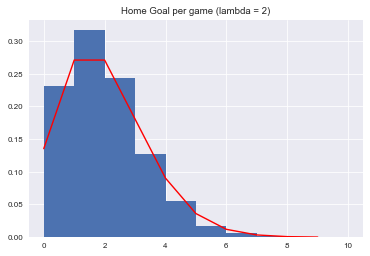

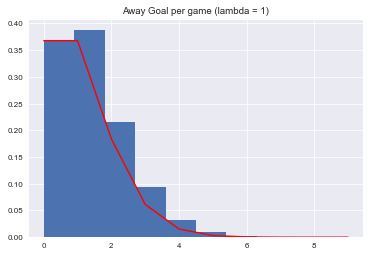

In [77]:
plt.title('Home Goal per game (lambda = 2)')
plt.hist(diff['homeGoalFT'],density = True)
X = np.arange( 0,10,1 )
plt.plot( X, poisson.pmf(X,2), 'r-' )
plt.show()
plt.title('Away Goal per game (lambda = 1)')
plt.hist(diff['awayGoalFT'],density = True)
plt.plot( X, poisson.pmf(X,1), 'r-' )
plt.show()

In [78]:
print(diff.groupby(['homeFormation'])['homeGoalFT'].mean())
print(diff.groupby(['awayFormation'])['awayGoalFT'].mean())

# As we can see 343d tactics is the most offensive tactics the mean of goals of home teams who are playing with this 
# tactics is 2.7 and corresponding away team mean is 1.777 which are the maximum from each of group

homeFormation
3142     1.741379
3412     1.477778
3421     1.692308
343      1.706294
343d     2.700000
3511     1.457627
352      1.498701
41212    1.532609
4132     1.000000
4141     1.417778
4222     1.600000
4231     1.588761
4312     1.497537
4321     1.404762
433      1.712312
4411     1.351421
442      1.449275
451      1.319149
532      1.062500
541      1.104167
Name: homeGoalFT, dtype: float64
awayFormation
3142     1.276923
3412     0.970297
3421     1.224490
343      1.166667
343d     1.777778
3511     1.106250
352      1.143939
41212    1.247126
4132     1.071429
4141     1.158397
4222     1.520833
4231     1.176206
4240     0.000000
4312     1.091837
4321     0.953488
433      1.340796
4411     0.955801
442      1.135249
451      0.687500
532      0.864407
541      0.878788
Name: awayGoalFT, dtype: float64


In [79]:
diff.drop(['awayFormation', 'homeFormation'], axis =1, inplace =True)

In [80]:
print(diff.groupby(['division'])['diff_Goal'].mean())
# So we can see that in La_Liga there is the most difference in goals between home and away teams though it was most
# predictable laegue

division
Bundesliga    0.352518
EPL           0.352632
La_Liga       0.462105
Ligue_1       0.382833
Serie_A       0.351237
Name: diff_Goal, dtype: float64


In [81]:
grouped = diff.groupby(['homeManagerName'])['Outcome'].mean()==diff.groupby(['homeManagerName'])['Outcome'].mean().max()
grouped[grouped==True]  #Managers which has 100 % result at their home games

homeManagerName
André Villas-Boas      True
Asier Santana          True
David Unsworth         True
Eddie Newton           True
Maurizio Pellegrino    True
Omar Daf               True
Name: Outcome, dtype: bool

In [82]:
lineup = np.array(diff['homeTeamLineUp'])
goalkeeper = []
for i in lineup:
    goalkeeper.append(i.split(',')[0])

In [83]:
diff['Home_Goalkeeper'] = goalkeeper

In [84]:
a = diff[diff['awayGoalPerShotsTotalFT']==min(diff['awayGoalPerShotsTotalFT'])]
b = a['Home_Goalkeeper'].value_counts()>30
b[b==True]
#Gianluigi Buffon can be considered as the most reliable goalkeeper

Gianluigi Buffon    True
Stéphane Ruffier    True
Manuel Neuer        True
Thibaut Courtois    True
Petr Cech           True
Hugo Lloris         True
Vincent Enyeama     True
Danijel Subasic     True
Anthony Lopes       True
Salvatore Sirigu    True
Joe Hart            True
David de Gea        True
Claudio Bravo       True
Samir Handanovic    True
José Reina          True
Name: Home_Goalkeeper, dtype: bool

In [85]:
a = df.groupby('homeTeam')['homeGoalFT'].mean().max()==df.groupby('homeTeam')['homeGoalFT'].mean()
print(a[a==True])
print(df.groupby('homeTeam')['homeGoalFT'].mean().max())

homeTeam
Barcelona    True
Name: homeGoalFT, dtype: bool
3.38947368421


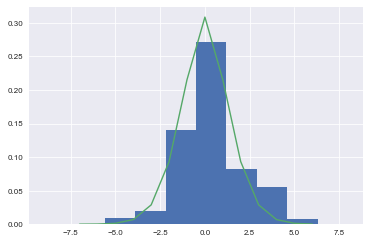

In [86]:
plt.hist(diff['diff_Goal'], density= True)
X = np.arange( -7,7,1 )
plt.plot(X, skellam.pmf(X, 1,1))
plt.show()
#Goal difference belongs to skallam distribution

# Working with numeric data

In [87]:
data_numeric = df.select_dtypes(exclude=["object"])
data_numeric = data_numeric.join(df.loc[:,['homeTeam','awayTeam']])


In [88]:
data_numeric.drop(['awayGoalHT','homeGoalHT','Year','Month','Day','id'],axis=1, inplace=True)

In [89]:
data_numeric = data_numeric.fillna(data_numeric.median()) #Filling missing values with column median


In [90]:
data_numeric.loc[data_numeric['homeGoalFT'] > data_numeric['awayGoalFT'],'Outcome'] = 2
data_numeric.loc[data_numeric['homeGoalFT'] == data_numeric['awayGoalFT'],'Outcome'] = 1
data_numeric.loc[data_numeric['homeGoalFT'] < data_numeric['awayGoalFT'],'Outcome'] = 0

In [91]:
home_col = [col for col in data_numeric if ((col.startswith('home')) & (col not in('homeTeam','Outcome')))]
away_col = [col for col in data_numeric if ((col.startswith('away')) & (col not in('awayTeam','Outcome')))]

In [92]:
def shift(data, group, lst):
    for each in lst:
        grouped = data.groupby(group)[each].shift(1).reset_index().set_index('index')
        data = data.drop(each, axis=1)
        data = data.join(grouped)
    return data

In [93]:
def roll(data, team, lst):
    for each in lst:
        grouped = data.groupby(team)[each].rolling(window=3,min_periods=0,
            center=False).mean().to_frame().reset_index().set_index('level_1').drop(team,axis=1)
        data.drop(each, axis=1, inplace=True)
        data = data.join(grouped)
    return data
    

In [94]:
data_numeric = shift(data_numeric, 'homeTeam', home_col)
data_numeric = shift(data_numeric, 'awayTeam', away_col)


In [95]:
data_numeric = roll(data_numeric, 'homeTeam', home_col)
data_numeric = roll(data_numeric, 'awayTeam', away_col)

In [96]:
data_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9127 entries, 0 to 9126
Data columns (total 83 columns):
homeTeam                   9127 non-null object
awayTeam                   9127 non-null object
Outcome                    9127 non-null float64
homeTacklesTotalHT         8988 non-null float64
homeShotsTotalHT           8988 non-null float64
homeDribbleSuccessHT       8988 non-null float64
homeFoulsCommitedFT        8988 non-null float64
homeAerialsTotalFT         8988 non-null float64
homeRatingsHT              8988 non-null float64
homeInterceptionsHT        8988 non-null float64
homePassesKeyFT            8988 non-null float64
homeCornersTotalFT         8988 non-null float64
homeAerialsTotalHT         8988 non-null float64
homeShotsBlockedFT         8988 non-null float64
homeCornersTotalHT         8988 non-null float64
homeDribbleSuccessFT       8988 non-null float64
homeDispossessedHT         8988 non-null float64
homeShotsBlockedHT         8988 non-null float64
homeTackleSuc

In [97]:
data_numeric= data_numeric.dropna().reset_index()

In [98]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    return dataset, col_corr

In [99]:
a = correlation(data_numeric, 0.9) # removing columns which have high correlation with each other

In [100]:
data_numeric = a[0]
col_corr = a[1]

In [101]:
data_numeric['Outcome'].value_counts()

2.0    4102
0.0    2601
1.0    2222
Name: Outcome, dtype: int64

In [102]:
final = data_numeric.drop(['homeTeam','awayTeam','index'], axis=1)

In [103]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8925 entries, 0 to 8924
Data columns (total 71 columns):
Outcome                    8925 non-null float64
homeTacklesTotalHT         8925 non-null float64
homeShotsTotalHT           8925 non-null float64
homeDribbleSuccessHT       8925 non-null float64
homeFoulsCommitedFT        8925 non-null float64
homeAerialsTotalFT         8925 non-null float64
homeRatingsHT              8925 non-null float64
homeInterceptionsHT        8925 non-null float64
homePassesKeyFT            8925 non-null float64
homeCornersTotalFT         8925 non-null float64
homeShotsBlockedFT         8925 non-null float64
homeCornersTotalHT         8925 non-null float64
homeDribbleSuccessFT       8925 non-null float64
homeDispossessedHT         8925 non-null float64
homeShotsBlockedHT         8925 non-null float64
homeTackleSuccessHT        8925 non-null float64
homeDribblesWonHT          8925 non-null float64
homePossessionFT           8925 non-null float64
homeDribble

In [104]:
#I implemented function not to write the same thing over and over again
def describe(model):
    print('Accuracy is',model.score(x_test, y_test)*100) 
    print(model.best_params_)
    print('Cross validation score',np.mean(cross_val_score(model, x, y, cv=5))*100)
    pred = model.predict(x_test)

In [105]:
y = final.Outcome.values
x = final.drop('Outcome', axis = 1).values


In [106]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=42)

# Decission tree, KNN and Random Forest 

In [107]:
parameters_tree = {'max_depth': np.arange(2, 7),
                    'min_samples_leaf':[i for i in range(30,200,10)]}
tree = GridSearchCV(DecisionTreeClassifier(), parameters_tree, scoring='accuracy')
tree.fit(x_train,y_train)



GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([2, 3, 4, 5, 6]), 'min_samples_leaf': [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [108]:
describe(tree)


Accuracy is 49.1935483871
{'max_depth': 3, 'min_samples_leaf': 100}
Cross validation score 49.5461743373


In [109]:
parameters_knn = {'n_neighbors': np.arange(1, 10,1)}
knn = GridSearchCV(KNeighborsClassifier(), parameters_knn, scoring='accuracy')
knn.fit(x_train,y_train)
describe(knn)
#As for KNN it works poorer than for tree algorithms 

Accuracy is 43.8172043011
{'n_neighbors': 9}
Cross validation score 43.2835122129


In [110]:
params_rf = {"n_estimators": [10, 20, 30, 40, 45, 50 ,55, 60],
             "max_features": ['auto', None],
             "min_samples_split": sp_randint(2, 13),
             "min_samples_leaf": sp_randint(1, 11),
             "bootstrap": [True, False],
             }
RandomForest = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=params_rf, n_iter=10)
RandomForest.fit(x_train,y_train)
print('Accuracy is',RandomForest.score(x_test, y_test)*100) 
print(RandomForest.best_params_)


Accuracy is 51.0752688172
{'bootstrap': False, 'max_features': 'auto', 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 60}


In [111]:
prediction_rf = RandomForest.predict(x_test)
print(recall_score(y_test,prediction_rf,average=None)*100)

[ 34.86370158   2.64150943  87.86069652]


In [112]:
# Random Forest performs well when predicting loses of home team. The problem is predicting draws.

# Scaling our data

In [113]:
final_scaled = final.copy()

In [114]:
y = final_scaled.Outcome.values
final_scaled.drop('Outcome', axis = 1, inplace = True)

In [115]:
for i in range(len(final_scaled.columns)):
    A = final_scaled.iloc[:,i]
    final_scaled.iloc[:,i] = (final_scaled.iloc[:,i]-A.min())/(A.max()-A.min())

In [116]:
x_scaled = final_scaled.values

In [117]:
x_train_sc, x_test_sc, y_train, y_test = train_test_split(x_scaled,y,test_size=0.25,random_state=42)

#  PCA

In [118]:
pca = PCA(n_components=2)

In [119]:
pca.fit(x_scaled)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [120]:
pca.explained_variance_ratio_


array([ 0.12080712,  0.09803299])

In [121]:
principalComponents = pca.fit_transform(x)

In [122]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [123]:
finalDf = pd.concat([principalDf, final[['Outcome']]], axis = 1)

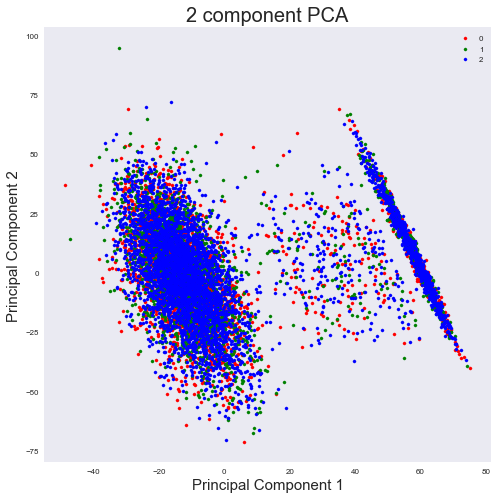

In [124]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = final['Outcome'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()
# As we can see from the plot when after running PCA, it is not much visible difference between 3 outcomes of the game

In [125]:
pca2 = PCA(n_components=10)
pca2.fit(x_scaled)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

[ 0.12  0.22  0.31  0.39  0.43  0.47  0.51  0.54  0.57  0.6 ]


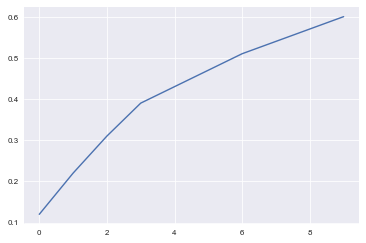

In [126]:
PCA_plot_y = np.round(np.cumsum(pca2.explained_variance_ratio_),2)
print(PCA_plot_y)

plt.plot(PCA_plot_y[:10])
plt.show()
# As the number of components is increasing the graph tends to 1, So we can see that 10 components together
# explain 0.6 variance of the dataset

# Neural Network using Keras

In [127]:
# Not it's time for using NN.
# I have now scaled  x, x_train and x_test, and corresponding y,y_train, y_test

In [134]:
seed = 42
np.random.seed(seed)

In [135]:
dummy_y = np_utils.to_categorical(y_train)
dummy_y # Getting dummy variables from y. If first column =1 then Home team win, if 2nd column = 0 then outcome=draw, 
# else if 3rd column =1 then home team loses

array([[ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.]], dtype=float32)

In [136]:
dummy_test =np_utils.to_categorical(y_test)

In [137]:

def baseline_model():
    # create modelx
    model = Sequential()
    model.add(Dense(8925, input_dim=69, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [138]:
keras = KerasClassifier(build_fn=baseline_model, epochs=3, batch_size=5, verbose=0)

In [ ]:
keras.fit(x_train_sc, dummy_y)
predictions = keras.predict(x_test_sc)

In [ ]:
keras.score(x_test_sc,dummy_test )
#Here we can see that Neural Networks with Kerasagain gives us  around 50% accuracy

In [ ]:
nn_predict = keras.predict(x_test_sc)
print(recall_score(y_test,nn_predict,average=None)*100)

In [142]:
mlp = MLPClassifier(random_state=42,hidden_layer_sizes=(20,20),activation='tanh',max_iter=2000,solver='sgd')
# This time we use tanh as activation function

In [143]:
mlp.fit(x_train_sc,y_train)
prediction_mlp = mlp.predict(x_test_sc)
print(recall_score(y_test,prediction_mlp,average=None)*100)

[ 36.8723099    0.          85.27363184]


In [144]:
mlp.score(x_test_sc, y_test)

0.49910394265232977

In [145]:
#From the above mentioned numbers we can see that MLPClassifier and KerasClassifier best predicts outcome=2 
# which was Away Team wins.
# However, It cannot identify draws unfortunately.

### Now we are going to change the possible value of our target variable. Now if outcome =0  it means that home team wins, and outcome = 1 if home team does not win(lose or draw)

In [146]:
y_new = np.zeros(len(y))
for i in range(len(y)):
    if y[i] == 0:
        y_new[i] = 0
    else:
        y_new[i] = 1
y_new  

array([ 1.,  1.,  0., ...,  1.,  0.,  1.])

In [147]:
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(x_scaled,y_new,test_size=0.1,random_state=42)

In [148]:
mlp.fit(x_train_new,y_train_new)
print("For test",mlp.score(x_test_new, y_test_new))
print("For train",mlp.score(x_train_new, y_train_new))
#Neural Networks' accuracy increased we can see. Now let's look at performance of Random Forest algorithm

For test 0.707726763718
For train 0.721862549801


In [ ]:
RandomForest.fit(x_train_new,y_train_new)
print('Accuracy is',RandomForest.score(x_test_new, y_test_new)*100) 
print(RandomForest.best_params_)
#Accuracy of of our models slightly increased

#### To sum up this prediction part we conclude for our dataset all models( Tree-based Algorthms and Neural Network) performed similiarly with similar accuracy and recall scores (except KNN). We did Principal Component Analysis(PCA) and conclude that in this case PCA cannot be useful for us. However, after reducing the possible outcomes of target variable we saw slight increase in accuracy of our model (from 50 % to 70%). Sure, there are also some models which can be used to find the best estimator of our target variable (e.g Gradient Boosting) but unfortunately our computers does not support enough computational power to do these all staff in one place. 
